In [1]:
# !nvidia-smi

**Initialize**

In [2]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import scipy.io
from sklearn.preprocessing import OneHotEncoder
from random import random
from IPython import display
from scipy import signal

tf.__version__

read_file=scipy.io.loadmat('Subset_Biosec3.mat') # Load data

**Set Target ID, GAN, PBGAN, Input**

In [3]:
ID = 1 # Target ID
GAN_model = 0 # GAN model. 0: DCGAN / 1: WGAN / 2: LSGAN
PBGAN = 1 # PBGAN or PBGAN (W) ON/OFF. 0: ON / 1: OFF
Data = 3 # Input. 0: DTW / 1: TP / 2: FP / 3: Cubic

subject = np.arange(1,21).tolist()
print('ID',ID)


ID 1


Text(0.5, 1.0, 'Data sample')

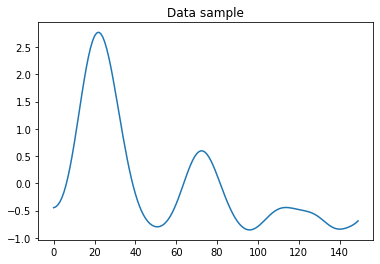

In [4]:
train_data = np.array(read_file['GAN_data'])[subject.index(ID), Data] # Assign train data from only target
train_data = np.reshape(train_data, [len(train_data),150,1,1])
n_feature = train_data.shape[1]

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(train_data[0,:,0,0])
plt.title('Data sample')

**Onehot Encoding and Data Shuffle**

In [5]:
enc = OneHotEncoder()

randIndx = np.arange(train_data.shape[0])
np.random.shuffle(randIndx)

train_data = train_data[randIndx] # Random shuffle the train data
train_data = train_data[:int(len(train_data) / 10) * 10] # Take most data for training

train_labels = np.ones((len(train_data),1)) # Train label


In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 10 # Mini-batch size

# Shuffle with mini-batch
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).batch(BATCH_SIZE)
labels = tf.data.Dataset.from_tensor_slices(train_labels).batch(BATCH_SIZE)

**The Generator**

In [7]:
def make_generator_model():
    if (GAN_model == 0) or (GAN_model == 1): # DCGAN or WGAN
      model = tf.keras.Sequential()
      # FC Layer
      model.add(layers.Dense(25*1*256, use_bias=False, input_shape=(200,)))
      model.add(layers.BatchNormalization()) # BN
      model.add(layers.LeakyReLU()) # LeakyReLu
      model.add(layers.Reshape((25, 1, 256)))
      assert model.output_shape == (None, 25, 1, 256)
      # Convolutional-Transpose Layer #1
      model.add(layers.Conv2DTranspose(128, (5, 1), strides=(1, 1), padding='same', use_bias=False)) # Conv-T
      assert model.output_shape == (None, 25, 1, 128)
      model.add(layers.BatchNormalization()) # BN
      model.add(layers.LeakyReLU()) # LeakyReLu
      # Convolutional-Transpose Layer #2
      model.add(layers.Conv2DTranspose(64, (5, 1), strides=(3, 1), padding='same', use_bias=False)) # Conv-T
      assert model.output_shape == (None, 75, 1, 64)
      model.add(layers.BatchNormalization()) # BN
      model.add(layers.LeakyReLU()) # LeakyReLu
      # Convolutional-Transpose Layer #3
      model.add(layers.Conv2DTranspose(32, (5, 1), strides=(1, 1), padding='same', use_bias=False)) # Conv-T
      assert model.output_shape == (None, 75, 1, 32)
      model.add(layers.BatchNormalization()) # BN
      model.add(layers.LeakyReLU()) # LeakyReLu
      # Convolutional-Transpose Layer #4
      model.add(layers.Conv2DTranspose(16, (5, 1), strides=(2, 1), padding='same', use_bias=False)) # Conv-T
      assert model.output_shape == (None, 150, 1, 16)
      model.add(layers.BatchNormalization()) # BN
      model.add(layers.LeakyReLU()) # LeakyReLu
      # Convolutional-Transpose Layer #5
      model.add(layers.Conv2DTranspose(1, (5, 1), strides=(1, 1), padding='same', use_bias=False)) # Conv-T
      # Output
      assert model.output_shape == (None, 150, 1, 1)

      return model

    elif GAN_model == 2: # LSGAN
      model = tf.keras.Sequential()
      # FC Layer
      model.add(layers.Dense(25*1*256, use_bias=False, input_shape=(200,)))
      model.add(layers.LeakyReLU()) # LeakyReLu
      model.add(layers.Reshape((25, 1, 256)))
      assert model.output_shape == (None, 25, 1, 256) 
      # Convolutional-Transpose Layer #1
      model.add(layers.Conv2DTranspose(128, (5, 1), strides=(1, 1), padding='same', use_bias=False)) # Conv-T
      assert model.output_shape == (None, 25, 1, 128)
      model.add(layers.LeakyReLU()) # LeakyReLu
      # Convolutional-Transpose Layer #2
      model.add(layers.Conv2DTranspose(64, (5, 1), strides=(3, 1), padding='same', use_bias=False)) # Conv-T
      assert model.output_shape == (None, 75, 1, 64)
      model.add(layers.LeakyReLU()) # LeakyReLu
      # Convolutional-Transpose Layer #3
      model.add(layers.Conv2DTranspose(32, (5, 1), strides=(1, 1), padding='same', use_bias=False)) # Conv-T
      assert model.output_shape == (None, 75, 1, 32)
      model.add(layers.LeakyReLU()) # LeakyReLu
      # Convolutional-Transpose Layer #4
      model.add(layers.Conv2DTranspose(16, (5, 1), strides=(2, 1), padding='same', use_bias=False)) # Conv-T
      assert model.output_shape == (None, 150, 1, 16)
      model.add(layers.LeakyReLU()) # LeakyReLu
      # Convolutional-Transpose Layer #5
      model.add(layers.Conv2DTranspose(1, (5, 1), strides=(1, 1), padding='same', use_bias=False)) # Conv-T
      # Output
      assert model.output_shape == (None, 150, 1, 1)

      return model

    else:
      print('Set the number between 0 and 2 for GAN model')

generator = make_generator_model()

**The Discriminator**

In [8]:
def make_discriminator_model():
    if GAN_model == 0: # DCGAN
      model = tf.keras.Sequential()
      # Convolutional Layer #1
      model.add(layers.Conv2D(16, (5, 1), strides=(1, 1), padding='same', input_shape=[150, 1, 1])) # Conv
      model.add(layers.BatchNormalization()) # BN
      model.add(layers.LeakyReLU()) # LeakyReLu
      model.add(layers.Dropout(0.5)) # Dropout
      # Convolutional Layer #2
      model.add(layers.Conv2D(32, (5, 1), strides=(2, 1), padding='same')) # Conv
      model.add(layers.BatchNormalization()) # BN
      model.add(layers.LeakyReLU()) # LeakyReLu
      model.add(layers.Dropout(0.5)) # Dropout
      # Convolutional Layer #3
      model.add(layers.Conv2D(64, (5, 1), strides=(1, 1), padding='same')) # Conv
      model.add(layers.BatchNormalization()) # BN
      model.add(layers.LeakyReLU()) # LeakyReLu
      model.add(layers.Dropout(0.5)) # Dropout
      # Convolutional Layer #4
      model.add(layers.Conv2D(128, (5, 1), strides=(3, 1), padding='same')) # Conv
      model.add(layers.BatchNormalization()) # BN
      model.add(layers.LeakyReLU()) # LeakyReLu
      model.add(layers.Dropout(0.5)) # Dropout
      # Convolutional Layer #5
      model.add(layers.Conv2D(256, (5, 1), strides=(1, 1), padding='same')) # Conv
      model.add(layers.BatchNormalization()) # BN
      model.add(layers.LeakyReLU()) # LeakyReLu
      model.add(layers.Dropout(0.5)) # Dropout
      # FC Layer + Output
      model.add(layers.Flatten())
      model.add(layers.Dense(1))
      model.add(layers.Activation('sigmoid')) # Sigmoid
      
      return model

    elif (GAN_model == 1) or (GAN_model == 2): # WGAN or LSGAN
      model = tf.keras.Sequential()
      # Convolutional Layer #1
      model.add(layers.Conv2D(16, (5, 1), strides=(1, 1), padding='same', input_shape=[150, 1, 1])) # Conv
      model.add(layers.LeakyReLU()) # LeakyReLu
      model.add(layers.Dropout(0.5)) # Dropout
      # Convolutional Layer #2
      model.add(layers.Conv2D(32, (5, 1), strides=(2, 1), padding='same')) # Conv
      model.add(layers.LeakyReLU()) # LeakyReLu
      model.add(layers.Dropout(0.5)) # Dropout
      # Convolutional Layer #3
      model.add(layers.Conv2D(64, (5, 1), strides=(1, 1), padding='same')) # Conv
      model.add(layers.LeakyReLU()) # LeakyReLu
      model.add(layers.Dropout(0.5)) # Dropout
      # Convolutional Layer #4
      model.add(layers.Conv2D(128, (5, 1), strides=(3, 1), padding='same')) # Conv
      model.add(layers.LeakyReLU()) # LeakyReLu
      model.add(layers.Dropout(0.5)) # Dropout
      # Convolutional Layer #5
      model.add(layers.Conv2D(256, (5, 1), strides=(1, 1), padding='same')) # Conv
      model.add(layers.LeakyReLU()) # LeakyReLu 
      model.add(layers.Dropout(0.5)) # Dropout
      # FC Layer + Output
      model.add(layers.Flatten())
      model.add(layers.Dense(1))    

      return model

    else:
      print('Set the number between 0 and 2 for GAN model')

discriminator = make_discriminator_model()

**The Generator Loss**

In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

if PBGAN == 0 : # PBGAN from original GANs

  def gradient(x): # Function for calculating gradient
      grad = []
      for i in range(n_feature-1):
        grad.append(x[:,i+1]-x[:,i])

      return tf.convert_to_tensor(tf.transpose(grad))

  def integral(y, x): # Function for calculating area
      dx = (x[-1] - x[0]) / (int(x.shape[0]) - 1)
      dx = tf.cast(dx,dtype=tf.float64)
      return ((y[:,0] + y[:,-1])/2 + tf.reduce_sum(y[:,1:-1],axis=1)) * dx

  def autocorr(x): # Function for calculating autocorrelation
      y = x - np.mean(x)
      norm = np.sum(y ** 2)
      correlated = np.correlate(x, x, mode='full') / norm

      return correlated[int(len(correlated)/2):]

  def generator_loss(images, generated_images, fake_output, epoch):
      if epoch>=10: # After epoch=10, use MSE loss with original loss (PBGAN)
        result_area = result_up = result_down = cor_1 = cor_2 = cor_3 = 0.0 # Features for PBGAN
        a = tf.constant(0, dtype=tf.float64)
        b = tf.constant(n_feature-1, dtype=tf.float64)
        x = tf.linspace(a, b, n_feature)
        
        temp_real = tf.cast(tf.reshape(images, [len(images), n_feature]), dtype=tf.float64) # Real data
        temp_gen = tf.cast(tf.reshape(generated_images, [len(generated_images), n_feature]), dtype=tf.float64) # Fake data
          
        result_area = tf.reduce_mean(tf.pow(tf.subtract(integral(temp_real, x), integral(temp_gen, x)),2)) # MSE from area feature

        r_sys_loc = tf.argmax(temp_real,axis=1) # Peak location in real data
        g_sys_loc = tf.argmax(temp_gen,axis=1) # Peak location in fake data
        grad_r = gradient(temp_real) # Gradient information for real data
        grad_g = gradient(temp_gen) # Gradient information for fake data

        r_up = []
        r_dw = []
        g_up = []
        g_dw = []
        cor_1_r_tmp = []       
        cor_2_r_tmp = []
        cor_3_r_tmp = []
        cor_1_g_tmp = []
        cor_2_g_tmp = []
        cor_3_g_tmp = []

        for i in range(len(r_sys_loc)):
          
          grad_r_tmp = tf.math.abs(grad_r[i, r_sys_loc[i] - 10:r_sys_loc[i]+ 15])
          grad_g_tmp = tf.math.abs(grad_g[i, g_sys_loc[i] - 10:g_sys_loc[i]+ 15])

          r_up.append(tf.cast(tf.math.reduce_max(grad_r_tmp[:][:10]), dtype=tf.float64)) # Max upward slope near peak (real_data)
          r_dw.append(tf.cast(tf.math.reduce_max(grad_r_tmp[:][10:]), dtype=tf.float64)) # Max downward slope near peak (real_data)
          g_up.append(tf.cast(tf.math.reduce_max(grad_g_tmp[:][:10]), dtype=tf.float64)) # Max upward slope near peak (fake_data)
          g_dw.append(tf.cast(tf.math.reduce_max(grad_g_tmp[:][10:]), dtype=tf.float64)) # Max downward slope near peak (fake_data)

          ac_r = autocorr(temp_real[i])
          ac_g = autocorr(temp_gen[i])        
          cor_1_r_tmp.append(ac_r[int((n_feature-1)/4)]) # Autocorrelation at 1/4 lag (real_data)
          cor_2_r_tmp.append(ac_r[int(2*(n_feature-1)/4)]) # Autocorrelation at 2/4 lag (real_data)
          cor_3_r_tmp.append(ac_r[int(3*(n_feature-1)/4)]) # Autocorrelation at 3/4 lag (real_data)
          cor_1_g_tmp.append(ac_g[int((n_feature-1)/4)]) # Autocorrelation at 1/4 lag (fake_data)
          cor_2_g_tmp.append(ac_g[int(2*(n_feature-1)/4)]) # Autocorrelation at 2/4 lag (fake_data)
          cor_3_g_tmp.append(ac_g[int(3*(n_feature-1)/4)]) # Autocorrelation at 3/4 lag (fake_data)

        result_up = tf.reduce_mean(tf.pow(tf.subtract(r_up, g_up),2)) # MSE from max upward slope feature
        result_down = tf.reduce_mean(tf.pow(tf.subtract(r_dw, g_dw),2)) # MSE from max downward slope feature

        cor_1 = tf.reduce_mean(tf.pow(tf.subtract(cor_1_r_tmp, cor_1_g_tmp),2)) # MSE from autocorrelation (1/4 lag) feature
        cor_2 = tf.reduce_mean(tf.pow(tf.subtract(cor_2_r_tmp, cor_2_g_tmp),2)) # MSE from autocorrelation (2/4 lag) feature
        cor_3 = tf.reduce_mean(tf.pow(tf.subtract(cor_3_r_tmp, cor_3_g_tmp),2)) # MSE from autocorrelation (3/4 lag) feature

        r_f, r_psd = signal.welch(temp_real, fs=100) # Power spectral density (PSD) in real data
        g_f, g_psd = signal.welch(temp_gen, fs=100) # PSD in fake data

        psd = tf.reduce_mean(tf.pow(tf.subtract(np.trapz(r_psd,axis=1), np.trapz(g_psd,axis=1)),2)) # MSE from area of PSD feature
        MSE_loss = 0.49*result_area + 0.58*result_up + 1*result_down + 0.39*cor_1 + 0.46*cor_2 + 0.21*cor_3 + 0.95*psd # Different weights for all features in proposed loss
        # MSE_loss = result_area + result_up + result_down + cor_1 + cor_2 + cor_3 + psd  # Same weights for all features in proposed loss

        if GAN_model == 0: # PBGAN-DC
          original_loss = tf.cast(cross_entropy(tf.ones_like(fake_output), fake_output), dtype=tf.float64) # cross entropy with fake

        elif GAN_model == 1: # PBGAN-W
          original_loss = tf.cast(-tf.reduce_mean(fake_output), dtype=tf.float64) # Loss for WGAN

        elif GAN_model == 2: # PBGAN-LS
          original_loss = tf.cast(tf.reduce_mean(tf.nn.l2_loss(fake_output - tf.ones_like(fake_output))) / 2, dtype=tf.float64) # L2 norm with fake

        else:    
          print('Set the number between 0 and 2 for GAN model')

        return original_loss + MSE_loss 

      else: # Before epoch 10, use only original loss function for better synthetic data

        if GAN_model == 0: # DCGAN
          original_loss = tf.cast(cross_entropy(tf.ones_like(fake_output), fake_output), dtype=tf.float64) # cross entropy with fake

        elif GAN_model == 1: # WGAN
          original_loss = tf.cast(-tf.reduce_mean(fake_output), dtype=tf.float64) # Loss for WGAN

        elif GAN_model == 2: # LSGAN
          original_loss = tf.cast(tf.reduce_mean(tf.nn.l2_loss(fake_output - tf.ones_like(fake_output))) / 2, dtype=tf.float64) # L2 norm with fake

        else:    
          print('Set the number between 0 and 2 for GAN model')

        return original_loss

elif PBGAN == 1: # Original GANs
  def generator_loss(images, generated_images, fake_output, epoch):

    if GAN_model == 0: # DCGAN
      original_loss = tf.cast(cross_entropy(tf.ones_like(fake_output), fake_output), dtype=tf.float64) # cross entropy with fake

    elif GAN_model == 1: # WGAN
      original_loss = tf.cast(-tf.reduce_mean(fake_output), dtype=tf.float64) # Loss for WGAN

    elif GAN_model == 2: # LSGAN
      original_loss = tf.cast(tf.reduce_mean(tf.nn.l2_loss(fake_output - tf.ones_like(fake_output))) / 2, dtype=tf.float64) # L2 norm with fake

    else:    
      print('Set the number between 0 and 2 for GAN model')

    return original_loss

else: 
  print('Set the number between 0 and 1 for PBGAN')

**The Discriminator Loss**

In [10]:
if GAN_model == 0: # DCGAN
  def discriminator_loss(real_output, fake_output):    
      real_loss = cross_entropy(tf.ones_like(real_output), real_output) # Cross entropy with real
      fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # Cross entropy with fake

      total_loss = real_loss + fake_loss

      return total_loss

elif GAN_model == 1: # WGAN
  def discriminator_loss(real_data, fake_data): 
    # Calculate the gradient penalty term 
    LAMBDA = 10
    alpha = tf.cast(tf.random.uniform([BATCH_SIZE, 150, 1, 1], 0.,1.), dtype=tf.float64)
    real_data = tf.cast(real_data, dtype=tf.float64)
    fake_data = tf.cast(fake_data, dtype=tf.float64)    
    interpolates = alpha * real_data + (1-alpha) * fake_data
    
    with tf.GradientTape() as gp_tape:
      gp_tape.watch(interpolates)
      pred = discriminator(interpolates)

    gradients = gp_tape.gradient(pred, [interpolates])[0]
    
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1,2,3]))

    gradient_penalty = tf.reduce_mean((slopes-1)**2) # Gradient penalty term

    real_output = discriminator(real_data, training=True)
    fake_output = discriminator(fake_data, training=True)
    
    wasserstein_dist = tf.cast(tf.reduce_mean(fake_output) - tf.reduce_mean(real_output), dtype=tf.float64) # Loss for WGAN 

    return wasserstein_dist + LAMBDA*gradient_penalty # Loss with gradient penalty term

elif GAN_model == 2: # LSGAN
  def discriminator_loss(real_output, fake_output):    
       
    loss_real = tf.reduce_mean(tf.nn.l2_loss(real_output - tf.ones_like(real_output))) # L2 norm with real
    loss_fake = tf.reduce_mean(tf.nn.l2_loss(fake_output - tf.zeros_like(fake_output))) # L2 norm with fake

    loss = (loss_real + loss_fake) / 2

    return loss

else:    
    print('Set the number between 0 and 2 for GAN model')


**Optimizers**

In [11]:
if GAN_model == 0: # DCGAN
  generator_optimizer = tf.keras.optimizers.Adam(1e-3)
  discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

elif GAN_model == 1: # WGAN
  generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1 = 0, beta_2 = 0.9) 
  discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1 = 0, beta_2 = 0.9)

elif GAN_model == 2: # LSGAN
  generator_optimizer = tf.keras.optimizers.RMSprop(1e-3)
  discriminator_optimizer = tf.keras.optimizers.RMSprop(1e-3)
else:    
  print('Set the number between 0 and 2 for GAN model')


**Training Set Up**

In [12]:
EPOCHS = 100
noise_dim = 200 # Size of input for generator
num_examples_to_generate = 10 # Number of generated synthetic data in each mini-batch

In [13]:
if (GAN_model == 0) or (GAN_model == 2): # DCGAN or LSGAN
  def train_step(images,label,epoch):  
      noise = tf.random.normal([BATCH_SIZE, noise_dim]) # Input for generator 

      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True) # Synthetic data
        generated_images = tf.reshape(generated_images, [len(generated_images),150]) 
        mean_generate = tf.reshape(tf.math.reduce_mean(generated_images,axis=1),[len(generated_images),1])
        std_generate = tf.reshape(tf.math.reduce_std(generated_images,axis=1),[len(generated_images),1])

        generated_images = tf.divide(tf.subtract(generated_images, mean_generate), std_generate) # Standardization
        generated_images = tf.reshape(generated_images, [len(generated_images),150,1,1])
        real_output = discriminator(images, training=True) 
        fake_output = discriminator(generated_images, training=True) 

        gen_loss = generator_loss(images, generated_images, fake_output, epoch) # Loss from generator
        disc_loss = discriminator_loss(real_output, fake_output) # Loss from discriminator

      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # Optimizer for generator 
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # Optimizer for discriminator


elif GAN_model == 1: # WGAN
  def train_step(images,label,epoch):  

      for _ in range(5): # Train discriminator 5 times more than generator

        noise = tf.random.normal([BATCH_SIZE, noise_dim]) # Input for generator
    
        with tf.GradientTape() as disc_tape:
          generated_images = generator(noise, training=True) # Synthetic data          
          generated_images = tf.reshape(generated_images, [len(generated_images),150])
          mean_generate = tf.reshape(tf.math.reduce_mean(generated_images,axis=1),[len(generated_images),1])
          std_generate = tf.reshape(tf.math.reduce_std(generated_images,axis=1),[len(generated_images),1])

          generated_images = tf.divide(tf.subtract(generated_images, mean_generate), std_generate) # Standardization
          generated_images = tf.reshape(generated_images, [len(generated_images),150,1,1])

          disc_loss = discriminator_loss(images, generated_images) # Loss from discriminator
          gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
          discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # Optimizer for discriminator     


      noise = tf.random.normal([BATCH_SIZE, noise_dim]) # Input for generator

      with tf.GradientTape() as gen_tape:        
        generated_images = generator(noise, training=True) # Synthetic data            
        generated_images = tf.reshape(generated_images, [len(generated_images),150])
        mean_generate = tf.reshape(tf.math.reduce_mean(generated_images,axis=1),[len(generated_images),1])
        std_generate = tf.reshape(tf.math.reduce_std(generated_images,axis=1),[len(generated_images),1])

        generated_images = tf.divide(tf.subtract(generated_images, mean_generate), std_generate) # Standardization
        generated_images = tf.reshape(generated_images, [len(generated_images),150,1,1])
    
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(images, generated_images, fake_output, epoch) # Loss from generator
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # Optimizer for generator




In [14]:
def train(dataset, label, epochs): # Train during epoch

  for epoch in range(epochs): 
    for image_batch, true_label in zip(train_dataset, labels):           
      
      _ = train_step(image_batch, true_label,epoch)


print('Learning Started!')
start_time = time.time()

_ = train(train_dataset, labels, EPOCHS) # Train start!

print('Learning Finished!')
print('Building time for GAN: {:.2f} seconds'.format(time.time()-start_time))    

Learning Started!
Learning Finished!
Building time for GAN: 200.08 seconds


Text(0.5, 1.0, 'Example of synthetic data')

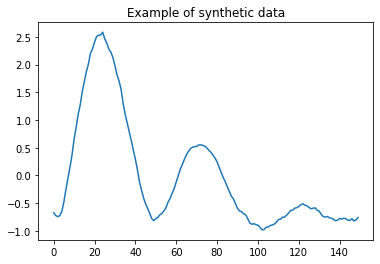

In [20]:
noise = tf.random.normal([120, noise_dim]) # Input for generator to build target's synthetic data

syn_data = generator(noise, training=False) # Target's synthetic data
syn_data = np.reshape(syn_data,[120,150])
mean_syn = np.reshape(np.mean(syn_data,axis=1),[len(syn_data),1])
std_syn = np.reshape(np.std(syn_data,axis=1),[len(syn_data),1])

syn_data = np.divide(syn_data - mean_syn, std_syn) # Standardization

fig2 = plt.figure()
ax = plt.subplot(111)
ax.plot(syn_data[3,:])
plt.title('Example of synthetic data')

In [21]:
fig.savefig('Original data sample.png')
fig2.savefig('Synthetic data sample.png')